Задача: предсказать следующие N значений временного ряда. В этом примере генерируется синусоида произвольной длины со случайным значением аплитуды и частоты. Мы хотим предсказать следующие 30 значений

In [82]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


In [83]:
def gen_data(batch = 16):
    t = np.arange(0,torch.randint(5,15,(1,)),step=0.1)
    X = torch.zeros(t.size-30,batch,1)
    Y = torch.zeros(30,batch,1)
    for i in range(batch):
        a = torch.rand(1)*3 + 0.1
        
        b = torch.rand(1)*4 + 0.2
        
        #X[i,:,0] =  torch.tensor(t)
        y = a*np.sin(b*t)
        X[:,i,0] =  y[:-30]
        Y[:,i,0] = y[-30:]
    return X,Y

In [84]:
device = 'cpu'
class Seq2Seq(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.GRU(input_size, hidden_size).to(device)
        self.decoder = nn.GRU(output_size, hidden_size).to(device)
        self.linear = nn.Linear(hidden_size, output_size).to(device)
    
    def forward(self, input_seq, teacher_forcing_ratio=0.5):
        encoder_outputs, hidden_state = self.encoder(input_seq)
        
        batch_size = input_seq.size(1)
        decoder_input = torch.zeros(1, batch_size, 1).to(device)  # Начальное значение декодера
        
        outputs = []
        for i in range(target_sequence.size(0)):
            
            decoder_output, hidden_state = self.decoder(decoder_input, hidden_state)
            output = self.linear(hidden_state)
            outputs.append(output)
            
            # Используем учителя для обучения (иногда показываем нейросети реальные данные). Это позволяет обучаться быстрее и эффективнее
            use_teacher_forcing = np.random.random() < teacher_forcing_ratio
            if use_teacher_forcing:
                decoder_input = target_sequence[i].unsqueeze(0)
            else:
                decoder_input = output
        
        outputs = torch.cat(outputs, dim=0)
        return outputs
    

In [74]:
model_seq = Seq2Seq(input_size=1, hidden_size=64, output_size=1)

In [92]:
# Определение функции потерь и оптимизатора
import torch.optim as optim
criterion = nn.MSELoss()
optimizer = optim.Adam(model_seq.parameters(), lr=0.01)

# Обучение модели
s = []
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    input_sequence,target_sequence =  gen_data(batch=16)

    output = model_seq(input_sequence)

    
    loss = criterion(output, target_sequence)
    loss.backward()
    optimizer.step()
    s.append(loss.detach().to('cpu'))

    if (epoch + 1) % 100 == 0:
        S = np.mean(s)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {S:.4f}')
        s = []


Epoch [100/500], Loss: 0.1082
Epoch [200/500], Loss: 0.0646
Epoch [300/500], Loss: 0.0537
Epoch [400/500], Loss: 0.0255
Epoch [500/500], Loss: 0.0103


In [93]:
x,y = gen_data(batch = 1)
output = model_seq(x,teacher_forcing_ratio = 0)
output = output.detach().squeeze()

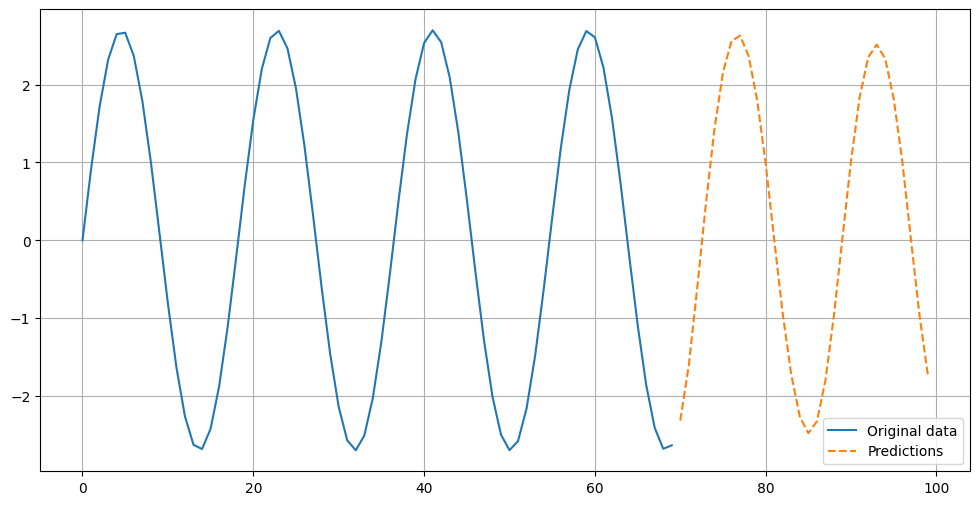

In [94]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(x)),x.detach().squeeze() , label='Original data')
plt.plot(np.arange(len(x), len(x)+30), output, label='Predictions', linestyle='dashed')
plt.legend()
plt.grid(True)
plt.show()